In [1]:
import os
import sys
import numpy as np
import itertools
import matplotlib.pyplot as plt
from orbithunter import *

# Why orbithunter?

## A terse non-technical explanation

Certain equations are hard to solve for two reasons: 1. the number of variables, 2. the relations between those variables.
In fact, for a certain class of equations, nonlinear equations, there are seldom any exact solutions; they must
be solved using computers. In certain settings this is hard, even for computers to manage, and so new tools
must be developed. Orbithunter offers itself as one of these tools. 


## A terse technical explanation

One of the main focuses of nonlinear dynamics and chaos research is the phenomenon of turbulence;
often synonymous with the Navier-Stokes equation. In the past twenty or so years, computational advances
have allowed for more advanced numerical experiments and investigations, each of which hoping to illuminate
the dark depths of the phenomenon of turbulence. 

Simulations of fluid flow have been used extensively in control and design problems e.g. airplane wings.
However, to get a general description of turbulence, one that is not bound to specific geometrical boundary conditions,
a more fundamental explanation is needed.

The nonlinear dynamicist's approach was to put turbulence under a microscope, looking at the minimal contains
required to sustain it. Naturally these computations began with "minimal cells"; computational domains large enough to sustain
turbulence yet remain computationally tractable; this might be smaller than you might imagine, representing
only small segments of pipe or plane Couette flow. By abstractifying fluid flow as a traversal of a
high dimensional space (technically infinite), periodic orbit theory was used to show that special solutions,
those which manifest as time invariant sets, shape the geometry of the state-space by virtue of their stable
and unstable manifolds. The instabilities, exponential in nature, prevent any long time prediction and are
the main instigator in all of this. 

## What to do

We can avoid these exponential instabilities by transforming our exponentially unstable initial value problem into
a variational, dynamics-less boundary value problem; by the conceptual migration to spacetime. This formulates
PDEs as systems of differential algebraic equations, instead.

This walkthrough demonstrates the user friendliness of the orbithunter package as well as its utility in finding unstable periodic orbits of the Kuramoto-Sivashinsky equation. 

## How to do it

By formulating turbulence as a space-time, variational formulation we can still find the same periodic orbits
in the dynamical systems approach; however, spacetime affords us with new capabilities not seen elsewhere, such as:

- The ability to find exponentially unstable solutions starting with modulated random noise
- The ability to include spatiotemporal domain sizes to vary as free parameters; essentially allowing the equations to     determine the important scales (or "learn" in machine learning parlance). 
- The ability to cut and paste (quite literally) periodic orbits together in a manner that is both supported by theory
  and also previously attempted in fluid dynamics research. 

These solutions, or initial conditions with which to find solutions, are represented via Python class objects using object oriented programming. Different solutions have different symemtries, which manifest naturally as subclasses. 
These ``Orbit`` objects, the basis of ``orbithunter`` are designed to give high-level access to a complex, scientific API. 


# The Kuramoto-Sivashinsky Equation

The K

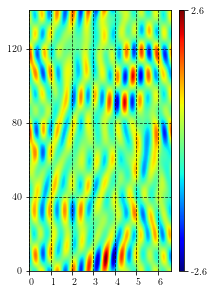

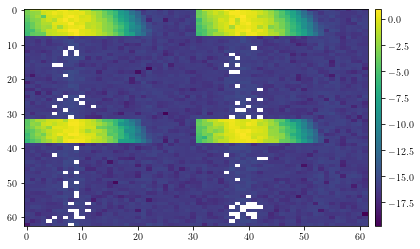

In [12]:
np.random.seed(99)
orbit = oh.OrbitKS().populate(seed=99, attr='all', temporal_modulation='truncate').rescale(2.5)
orbit.plot(padding=True)
orbit.mode_plot()

The plots correspond to the physical field and the spectrum of spatiotemporal Fourier modes populated by modulation
by a gaussian profile with respect to the spatial indices, and truncated with respect to a temporal index.
Once an Orbit instance is populated we can apply any of the numerical operations afforded to the OrbitKS class.
These include differentiation, symmetry operations, plotting, changing the discretization, or evaluate the
components of the Kuramoto-Sivashinsky equation. These operations can also be chained together, making it 
easy to write complex operations in a single line of code. First however, let's see how much we can improve
this randomly populated initial condition.

In [13]:
res = orbit.cost()
print(f"The cost before any numerical optimization is equal to {res:.5f}")

The cost before any numerical optimization is equal to 408.94525



-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : OrbitKS({"shape": [63, 62], "basis": "modes", "parameters": [141.01, 59.046, 0.0]})
Constraints : {'t': False, 'x': False, 's': True}
Initial cost : 408.9452528761927
Target cost tolerance : 1e-06
Maximum iteration number : 10000
-------------------------------------------------------------------------------------------------
#################################################
 Residual=39.3473048 after 5000 adjoint descent steps. Parameters=(141.25038058015224, 61.33302858702852, 0.0)
#################################################
Maximum number of iterations reached. exiting with cost=32.05653559103349


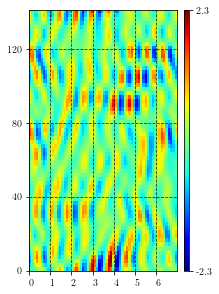

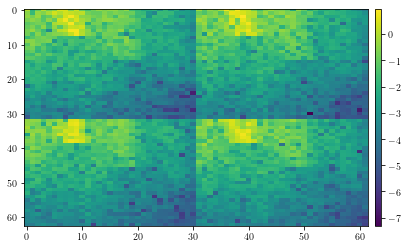

In [14]:
# Apply the hybrid method that was used as the primary method, historically. 
hunting_result = oh.hunt(orbit, verbose=True)
hunting_result.orbit.plot()
hunting_result.orbit.mode_plot()

In [15]:
# Apply the hybrid method that was used as the primary method, historically. 
hunting_result = oh.hunt(orbit, methods=('adj', 'lstsq'), preconditioning=True, maxiter=[100000, 20], verbose=True)


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : OrbitKS({"shape": [63, 62], "basis": "modes", "parameters": [141.01, 59.046, 0.0]})
Constraints : {'t': False, 'x': False, 's': True}
Initial cost : 408.9452528761927
Target cost tolerance : 1e-06
Maximum iteration number : 100000
-------------------------------------------------------------------------------------------------
#################################################
 Residual=3.0136204 after 5000 adjoint descent steps. Parameters=(141.04533229368286, 59.04627531511061, 0.0)
#################################################
 Residual=2.1209497 after 10000 adjoint descent steps. Parameters=(141.0573940823714, 59.04627594659463, 0.0)
#################################################
 Residual=1.7634545 after 15000 adjoint descent steps. Parameters=(141.0673973254965, 59.046276299427674, 0.0)
#################################################


While arbitrary numerical operations can be applied, the primary utilities offered by this package is the ability to extract and combine subdomains and orbits together in order to find larger solutions. To demonstrate, let us extract or "clip" some subdomains out of a large integrated trajectory.

In [16]:
import orbithunter.ks.physics as ks

In [17]:
integrated_trajectory = OrbitKS(parameters=(500, 500)).populate(attr='state', seed=0)
integrated_trajectory = ks.integrate(integrated_trajectory, integration_time=500, verbose=True,
                                          starting_point=0, step_size=0.25, return_trajectory=False)
integrated_trajectory = ks.integrate(integrated_trajectory, integration_time=500, verbose=True,
                                          starting_point=0, step_size=0.25, return_trajectory=False)
integrated_trajectory = ks.integrate(integrated_trajectory, integration_time=500, verbose=True,
                                          starting_point=0, step_size=0.25, return_trajectory=True)

NameError: name 'OrbitKS' is not defined

In [ ]:
integrated_trajectory = integrated_trajectory.resize(1024,512)
integrated_trajectory.plot(padding=False)

There are two primary methods of clipping. The first is much faster and natural, which is simply slicing the orbit
instance as one would a numpy array. However, this can take some trial and error, and so the more precise alternative
is to use the "clip" function. This allows one to provide the dimensions of the domain that they would like to clip out
of the larger array. Now, because all clippings are aperiodic by definition, two extra steps are recommended; setting
higher order modes equal to zero (most easily done via 2 resizings) and assuming the clipping is a ```RelativeOrbitKS```

In [ ]:
sliced_subdomain = integrated_trajectory[-64:, :32]
clipped_subdomain = clip(integrated_trajectory, ((0, sliced_subdomain.t), (0, sliced_subdomain.x/(2*pi*np.sqrt(2)))))
integrated_trajectory[-64:, :32].plot()
clipped_subdomain.plot()
(sliced_subdomain-clipped_subdomain).plot()

These clippings can be used to find larger orbits, but first it would befit us to find the orbit that we claim
these clippings shadow. 

In [ ]:
clip_result = hunt(clipped_subdomain.transform(to='modes').resize(32,32), methods=('adj', 'lstsq'),
                   maxiter=[100000, 500], preconditioning=True, verbose=True)

In [ ]:
clip_result.orbit.plot(padding=True)
clip_result.orbit.mode_plot()

The idea is "simple" instead of describing chaotic nonlinear pdes as
exponentially unstable dynamical systems (initial value problem) it is instead treated as a $(D+1)$ dimensional boundary value problem. This work only uses variational methods; time integration is possible but it is in no way involved
in the optimization or any other process.